# Notebook 07 — Regime Transitions & Practical Monitoring

Turn the macro framework into something operational:
- Detect regime changes
- Characterize what changes, when
- Produce monitoring artifacts you could update monthly
- Stay descriptive (no signals, no alpha claims)

In [1]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

from macro_utils.utils import (
    build_transformed_dataset,
    prepare_plot_df,
)
from macro_utils.regimes import (
    build_macro_regimes,
    detect_transitions,
)

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_OUTPUTS = PROJECT_ROOT / "data" / "outputs"
DATA_OUTPUTS.mkdir(parents=True, exist_ok=True)

In [2]:
# load data

monthly = pd.read_csv(
    DATA_RAW / "fred_monthly.csv",
    index_col=0,
    parse_dates=True
)

In [3]:
# canonical macro dataset

df = build_transformed_dataset(monthly)
df = build_macro_regimes(df)

df.head()

c:\Users\JR\OneDrive\Mini PC\FRED\macro_utils\transforms.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return series.pct_change(periods) * 100
c:\Users\JR\OneDrive\Mini PC\FRED\macro_utils\transforms.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return series.pct_change(1) * 100


,GDP_YoY,CPI_YoY,CPI_MoM,UNRATE,FEDFUNDS,Growth_Regime,Inflation_Regime,Policy_Regime,Macro_Regime
DATE,,,,,,,,,
1991-01-31,2.766649,5.647059,0.372578,6.4,6.91,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-02-28,2.766649,5.312500,0.074239,6.6,6.25,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-03-31,2.766649,4.821151,0.000000,6.8,6.12,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-04-30,2.799215,4.809930,0.222552,6.7,5.91,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-05-31,2.799215,5.034857,0.370096,6.9,5.78,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing


In [4]:
df["Macro_Regime"].value_counts()

Macro_Regime
Expansion / Inflationary / Easing           112
Expansion / Inflationary / Tightening       108
Expansion / Disinflationary / Tightening    103
Expansion / Disinflationary / Easing         78
Contraction / Disinflationary / Easing       17
Contraction / Inflationary / Easing           1
Name: count, dtype: int64

Levels describe *state*.
Transitions describe *change*.

Most macro risk is concentrated around:
- regime shifts
- turning points
- inflection periods

This notebook focuses on detecting and understanding those transitions.

In [5]:
# detect macro regime transitions

macro_transitions = detect_transitions(df["Macro_Regime"])
macro_transitions.head()

,date,from,to
0,1993-12-31,Expansion / Inflationary / Easing,Expansion / Inflationary / Tightening
1,1994-01-31,Expansion / Inflationary / Tightening,Expansion / Disinflationary / Tightening
2,1994-02-28,Expansion / Disinflationary / Tightening,Expansion / Inflationary / Tightening
3,1994-04-30,Expansion / Inflationary / Tightening,Expansion / Disinflationary / Tightening
4,1994-07-31,Expansion / Disinflationary / Tightening,Expansion / Inflationary / Tightening


In [6]:
# transition frequency table

transition_counts = (
    macro_transitions
    .groupby(["from", "to"])
    .size()
    .sort_values(ascending=False)
)

transition_counts

from                                      to                                      
Expansion / Disinflationary / Easing      Expansion / Inflationary / Easing           9
Expansion / Disinflationary / Tightening  Expansion / Disinflationary / Easing        8
Expansion / Inflationary / Tightening     Expansion / Disinflationary / Tightening    8
Expansion / Inflationary / Easing         Expansion / Inflationary / Tightening       7
Expansion / Disinflationary / Easing      Expansion / Disinflationary / Tightening    6
Expansion / Disinflationary / Tightening  Expansion / Inflationary / Tightening       6
Expansion / Inflationary / Easing         Expansion / Disinflationary / Easing        6
Expansion / Inflationary / Tightening     Expansion / Inflationary / Easing           5
Contraction / Disinflationary / Easing    Expansion / Disinflationary / Easing        2
Contraction / Inflationary / Easing       Contraction / Disinflationary / Easing      1
Expansion / Disinflationary / Easing 

In [7]:
# timeline of macro regime changes

plot_df = prepare_plot_df(df)

fig = px.scatter(
    plot_df,
    x="DATE",
    y="Macro_Regime",
    color="Macro_Regime",
    title="Macro Regime Timeline with Transitions",
    height=350
)

fig.update_yaxes(showticklabels=False)
fig.show()

In [8]:
# focused transitions: growth only

growth_transitions = detect_transitions(df["Growth_Regime"])
growth_transitions.head()

,date,from,to
0,2008-10-31,Expansion,Contraction
1,2009-10-31,Contraction,Expansion
2,2020-04-30,Expansion,Contraction
3,2020-10-31,Contraction,Expansion


In [9]:
# pre/post transition comparison template

WINDOW = 6

def pre_post_summary(series, transition_dates, window=6):
    records = []

    for d in transition_dates:
        if d not in series.index:
            continue

        pre = series.loc[
            d - pd.DateOffset(months=window):
            d - pd.DateOffset(months=1)
        ].mean()

        post = series.loc[
            d + pd.DateOffset(months=1):
            d + pd.DateOffset(months=window)
        ].mean()

        records.append({
            "date": d,
            "pre": pre,
            "post": post,
            "delta": post - pre
        })

    return pd.DataFrame(records)

In [10]:
# example: GDP growth around contractions

contraction_dates = growth_transitions.loc[
    growth_transitions["to"] == "Contraction",
    "date"
]

pre_post_gdp = pre_post_summary(
    df["GDP_YoY"],
    contraction_dates,
    window=6
)

pre_post_gdp

,date,pre,post,delta
0,2008-10-31,2.759237,-1.722318,-4.481555
1,2020-04-30,4.124308,-2.726370,-6.850678


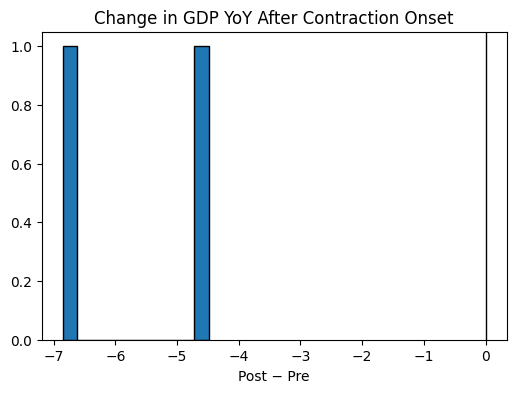

In [11]:
# distribution of pre/post changes

plt.figure(figsize=(6, 4))
plt.hist(pre_post_gdp["delta"], bins=10, edgecolor="black")
plt.axvline(0, color="black", lw=1)
plt.title("Change in GDP YoY After Contraction Onset")
plt.xlabel("Post − Pre")
plt.show()

In [12]:
# current transition state

latest_date = df.index.max()

current_state = {
    "date": latest_date.date().isoformat(),
    "macro_regime": df.loc[latest_date, "Macro_Regime"],
    "growth_regime": df.loc[latest_date, "Growth_Regime"],
    "inflation_regime": df.loc[latest_date, "Inflation_Regime"],
    "policy_regime": df.loc[latest_date, "Policy_Regime"],
}

current_state

{'date': '2025-12-31',
 'macro_regime': 'Expansion / Inflationary / Easing',
 'growth_regime': 'Expansion',
 'inflation_regime': 'Inflationary',
 'policy_regime': 'Easing'}

In [13]:
# export current state

transition_path = DATA_OUTPUTS / "macro_transition_monitor.csv"

pd.DataFrame([current_state]).to_csv(
    transition_path,
    index=False
)

transition_path

WindowsPath('c:/Users/JR/OneDrive/Mini PC/FRED/data/outputs/macro_transition_monitor.csv')